In [180]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from tensorflow import keras
import tensorflow as tf
import yfinance as yf
from datetime import datetime, timedelta

In [181]:
nvda_data = yf.download("NVDA", start="2020-01-01", end="2025-02-28")  #
nvda_data.to_csv('NVIDIA_stock_data.csv')  # Save to CSV
# Read the downloaded data
stock_data = pd.read_csv('NVIDIA_stock_data.csv')


[*********************100%***********************]  1 of 1 completed


In [182]:
stock_data.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,NVDA,NVDA,NVDA,NVDA,NVDA
1,Date,NaN,NaN,NaN,NaN,NaN
2,2020-01-02,5.972160816192627,5.972160816192627,5.892751478140193,5.943284736428357,237536000
3,2020-01-03,5.8765716552734375,5.920384087732343,5.827531643498655,5.852425081823098,205384000
4,2020-01-06,5.901214122772217,5.906441700582744,5.757082063251852,5.783219952304488,262636000


In [183]:
def compute_historical_params(stock_data):
    # Convert 'Close' column to numeric, handling potential errors
    stock_data['Close'] = pd.to_numeric(stock_data['Close'], errors='coerce')
    stock_data['Log_Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))

    # Historical drift (Annualized)
    mu_hist = stock_data['Log_Returns'].mean() * 252

    # Historical volatility (Annualized)
    sigma_hist = stock_data['Log_Returns'].std() * np.sqrt(252)

    return mu_hist, sigma_hist

In [184]:
def predict_ml_params(stock_data):
    # Calculate log returns
    stock_data['Log_Returns'] = np.log(stock_data['Close'] / stock_data['Close'].shift(1))
    stock_data.dropna(inplace=True)

    # Define features and target
    X = stock_data[['Open', 'High', 'Low', 'Volume']]
    y_mu = stock_data['Log_Returns'].rolling(252).mean().shift(-1) * 252  # Annualized drift
    y_sigma = stock_data['Log_Returns'].rolling(252).std().shift(-1) * np.sqrt(252)  # Annualized volatility

    # Drop rows with NaNs in y_mu and y_sigma
    X = X.loc[y_mu.dropna().index]
    y_mu = y_mu.dropna()
    y_sigma = y_sigma.dropna()

    # Train-test split
    X_train, X_test, y_train_mu, y_test_mu = train_test_split(X, y_mu, test_size=0.2, random_state=42)
    X_train, X_test, y_train_sigma, y_test_sigma = train_test_split(X, y_sigma, test_size=0.2, random_state=42)

    # Train models
    model_mu = RandomForestRegressor(n_estimators=100, random_state=42)
    model_sigma = RandomForestRegressor(n_estimators=100, random_state=42)

    model_mu.fit(X_train, y_train_mu)
    model_sigma.fit(X_train, y_train_sigma)

    # Predict
    predicted_mu = model_mu.predict(X_test).mean()
    predicted_sigma = model_sigma.predict(X_test).mean()

    return predicted_mu, predicted_sigma

In [185]:
def optimize_blend(mu_hist, sigma_hist, mu_ml, sigma_ml):

    alphas = np.linspace(0, 1, 21)  # Test alpha values from 0 to 1 in steps .05
    betas = np.linspace(0, 1, 21)   # Test beta values from 0 to 1

    best_alpha, best_beta = 0.5, 0.5  # Default values
    best_score = float('inf')

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for alpha in alphas:
        for beta in betas:
            blended_mu = alpha * mu_hist + (1 - alpha) * mu_ml
            blended_sigma = beta * sigma_hist + (1 - beta) * sigma_ml

            errors = []
            for train_idx, test_idx in kf.split(np.arange(5)):  # Proper k-fold split
                # Dummy cross-validation using mean squared error
                error = mean_squared_error([mu_hist, sigma_hist], [blended_mu, blended_sigma])
                errors.append(error)

            avg_error = np.mean(errors)

            if avg_error < best_score:
                best_score = avg_error
                best_alpha, best_beta = alpha, beta

    return best_alpha, best_beta


In [186]:
def simulate_stock_paths(S0, mu, sigma, T, dt, num_paths):
    np.random.seed(42)
    steps = int(T / dt)
    paths = np.zeros((steps, num_paths))
    paths[0] = S0

    for t in range(1, steps):
        Z = np.random.normal(0, 1, num_paths)
        paths[t] = paths[t-1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)

    return paths


In [ ]:
def structured_note_payoff(paths, initial_price, nominal=1000, risk_free_rate=0.0406):
    num_paths = paths.shape[1]
    total_payoffs = np.zeros(num_paths)

    trade_date = datetime(2025, 2, 28)
    coupon_valuation_dates = [
        datetime(2025, 6, 13),
        datetime(2025, 9, 15),
        datetime(2025, 12, 15),
        datetime(2026, 3, 13)
    ]
    interest_payment_dates = [
        datetime(2025, 6, 18),
        datetime(2025, 9, 18),
        datetime(2025, 12, 18),
        datetime(2026, 3, 18)
    ]
    maturity_date = datetime(2026, 3, 18)

    results = []
    for i in range(num_paths):
        path = paths[:, i]
        accumulated_coupons = 0
        early_redeemed = False
        coupons = []

        for idx, (t_val, t_pay) in enumerate(zip(coupon_valuation_dates, interest_payment_dates)):
            days_from_trade = np.busday_count(trade_date.date(), t_val.date())
            days_from_trade = min(days_from_trade, len(path) - 1)
            ri_value = (path[days_from_trade] / initial_price) * 100

            if ri_value >= 100:
                days_to_payment = np.busday_count(trade_date.date(), t_pay.date())
                discount_factor = np.exp(-risk_free_rate * (days_to_payment / 260))
                total_payoffs[i] = (nominal + accumulated_coupons + 48.40) * discount_factor
                coupons.append({
                    'amount': accumulated_coupons + 48.40,
                    'day': t_pay,
                    'quarter': f'Q{idx+1}'
                })
                early_redeemed = True
                break

            if ri_value >= 75:
                days_to_payment = np.busday_count(trade_date.date(), t_pay.date())
                discount_factor = np.exp(-risk_free_rate * (days_to_payment / 260))
                coupon_to_pay = accumulated_coupons + 48.40
                total_payoffs[i] += coupon_to_pay * discount_factor
                coupons.append({
                    'amount': coupon_to_pay,
                    'day': t_pay,
                    'quarter': f'Q{idx+1}'
                })
                accumulated_coupons = 0
            else:
                accumulated_coupons += 48.40

        if not early_redeemed:
            days_to_maturity = np.busday_count(trade_date.date(), maturity_date.date())
            days_to_maturity = min(days_to_maturity, len(path) - 1)
            final_price = path[days_to_maturity]
            ri_value_final = (final_price / initial_price) * 100
            discount_factor_final = np.exp(-risk_free_rate * (days_to_maturity / 260))

            if ri_value_final >= 75:
                total_payoffs[i] += (nominal + accumulated_coupons) * discount_factor_final
            else:
                loss = 1.3333 * (75 - ri_value_final) * nominal / 100
                total_payoffs[i] += max(0, nominal - loss) * discount_factor_final

        results.append({
            'quarter': f'Q{idx+1}' if early_redeemed else 'Q4',
            'day': t_pay if early_redeemed else maturity_date,
            'price': ri_value_final if not early_redeemed else (path[days_from_trade] / initial_price) * 100,
            'coupon_schedule': coupons,
            'principal': nominal if (not early_redeemed and ri_value_final >= 75) else max(0, nominal - loss) if not early_redeemed else nominal,
            'penalized': not early_redeemed and ri_value_final < 75
        })

    results_df = pd.DataFrame(results)

    def discount_cashflows(row):
        coupon_pv = sum(
            coup['amount'] * np.exp(-risk_free_rate * np.busday_count(trade_date.date(), coup['day'].date()) / 260)
            for coup in row['coupon_schedule']
        )
        principal_pv = row['principal'] * np.exp(-risk_free_rate * np.busday_count(trade_date.date(), row['day'].date()) / 260)
        return coupon_pv + principal_pv

    results_df['discounted_payout'] = results_df.apply(discount_cashflows, axis=1)

    # Calculate key probabilities
    penalty_rate = results_df['penalized'].mean()
    principal_recovery = results_df['principal'].mean() / nominal
    early_redemption_rate = len(results_df[results_df['quarter'] != 'Q4']) / num_paths
    coupon_probability = len(results_df[results_df['coupon_schedule'].apply(len) > 0]) / num_paths

    # Print probabilities
    print(f"Probability of Full Principal: {1-penalty_rate:.1%}")
    print(f"Principal Recovery (if penalized): {principal_recovery:.1%}")
    print(f"Early Redemption Probability: {early_redemption_rate:.1%}")
    print(f"Coupon Payment Probability: {coupon_probability:.1%}")

    plt.figure(figsize=(8, 6))
    plt.hist(results_df['discounted_payout'], bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Discounted Payout')
    plt.ylabel('Frequency')
    plt.title('Distribution of Discounted Payouts')
    plt.grid(True)
    plt.show()

    return total_payoffs, results_df


In [188]:
def train_neural_network(stock_paths, payoffs):
    model = keras.Sequential([
        keras.layers.Dense(64, activation="relu", input_shape=(1,)),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.Dense(1, activation="linear")
    ])

    model.compile(optimizer="adam", loss="mse")

    X_train = stock_paths[-1, :].reshape(-1, 1)
    y_train = payoffs.reshape(-1, 1)

    model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=32)

    return model


In [189]:
# Load NVIDIA stock data
stock_data = pd.read_csv('NVIDIA_stock_data.csv')

In [190]:
# Compute historical parameters
mu_hist, sigma_hist = compute_historical_params(stock_data)

# Compute ML-based parameters
mu_ml, sigma_ml = predict_ml_params(stock_data)

# Optimize alpha and beta using cross-validation
best_alpha, best_beta = optimize_blend(mu_hist, sigma_hist, mu_ml, sigma_ml)  # Ensure all arguments are passed!

# Compute final blended parameters using optimal weights
mu_final = best_alpha * mu_hist + (1 - best_alpha) * mu_ml
sigma_final = best_beta * sigma_hist + (1 - best_beta) * sigma_ml

# Print results
print("Historical Parameters:")
print(f"Drift (mu_hist): {mu_hist:.6f}")
print(f"Volatility (sigma_hist): {sigma_hist:.6f}")

print("\nMachine Learning Parameters:")
print(f"Drift (mu_ml): {mu_ml:.6f}")
print(f"Volatility (sigma_ml): {sigma_ml:.6f}")

print("\nOptimized Blending Weights:")
print(f"Alpha (best_alpha): {best_alpha:.2f}")
print(f"Beta (best_beta): {best_beta:.2f}")

print("\nFinal Blended Parameters:")
print(f"Drift (mu_final): {mu_final:.6f}")
print(f"Volatility (sigma_final): {sigma_final:.6f}")


Historical Parameters:
Drift (mu_hist): 0.584084
Volatility (sigma_hist): 0.542041

Machine Learning Parameters:
Drift (mu_ml): 0.593815
Volatility (sigma_ml): 0.519890

Optimized Blending Weights:
Alpha (best_alpha): 1.00
Beta (best_beta): 1.00

Final Blended Parameters:
Drift (mu_final): 0.584084
Volatility (sigma_final): 0.542041


In [191]:
# Monte Carlo Simulation

# Calculate time horizon (T) dynamically using business days
trade_date = datetime(2025, 2, 28)  # Trade date
maturity_date = datetime(2026, 3, 18)  # Maturity date
time_horizon_days = np.busday_count(trade_date.date(), maturity_date.date())  # Business days
T = time_horizon_days / 252  # Convert to years
print(T)
# Monte Carlo Simulation Parameters
S0 = 124.91
dt = 1 / 263  # Business day steps
num_paths = 10000

paths = simulate_stock_paths(S0, mu_final, sigma_final, T, dt, num_paths)


1.0833333333333333


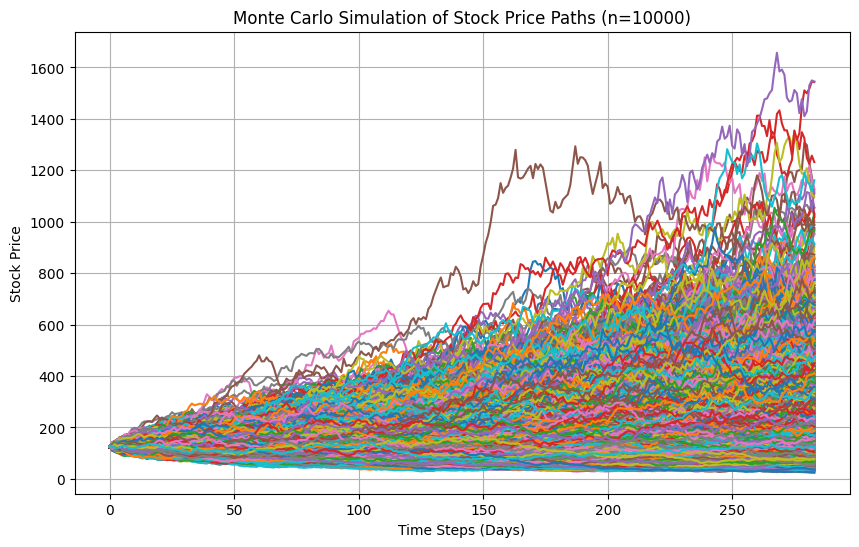

In [192]:
plt.figure(figsize=(10, 6))
plt.plot(paths)
plt.title(f"Monte Carlo Simulation of Stock Price Paths (n={num_paths})")
plt.xlabel("Time Steps (Days)")
plt.ylabel("Stock Price")
plt.grid(True)
plt.show()

Probability of Full Principal: 94.0%
Principal Recovery (if penalized): 98.6%
Early Redemption Probability: 86.1%
Coupon Payment Probability: 97.9%


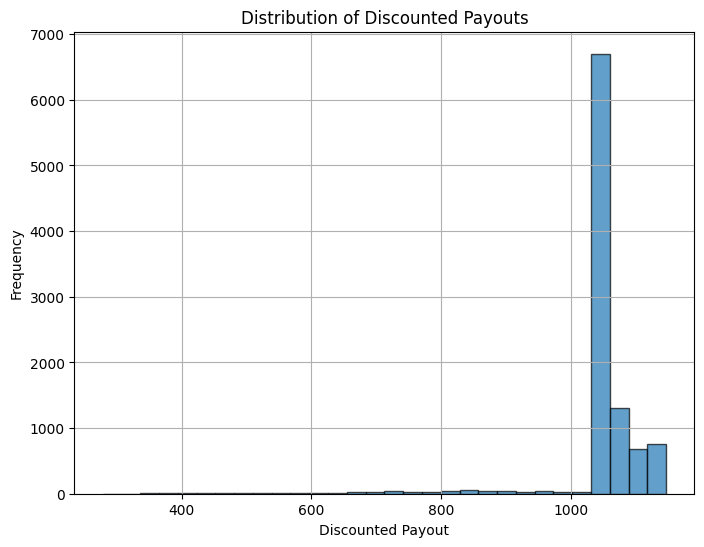

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [193]:
# Compute note payoffs
payoffs, results_df = structured_note_payoff(paths, S0)
payoffs = np.array(payoffs)  # Convert tuple to NumPy array if needed

# Train neural network
model = train_neural_network(paths, payoffs)


In [194]:
# Compute key metrics
avg_payout = results_df['principal'].mean()
penalty_rate = results_df['penalized'].mean()
nominal = 1000  # Define nominal here
principal_recovery = results_df['principal'].mean() / nominal
early_redemption_rate = len(results_df[results_df['quarter'] != 'Q4']) / len(results_df)
coupon_probability = len(results_df[results_df['coupon_schedule'].apply(len) > 0]) / len(results_df)

# Print summary

print(f"\n{'KEY PERFORMANCE METRICS'}")
print(f"{'Average Total Return:':<40} ${avg_payout:.2f} ({avg_payout/nominal:.1%} of principal)")
print(f"{'Probability of Full Principal:':<40} {1 - penalty_rate:.1%}")
print(f"{'Principal Recovery (if penalized):':<40} {principal_recovery:.1%}")
print(f"{'Early Redemption Probability:':<40} {early_redemption_rate:.1%}")
print(f"{'Coupon Payment Probability:':<40} {coupon_probability:.1%}")



KEY PERFORMANCE METRICS
Average Total Return:                    $985.89 (98.6% of principal)
Probability of Full Principal:           94.0%
Principal Recovery (if penalized):       98.6%
Early Redemption Probability:            86.1%
Coupon Payment Probability:              97.9%


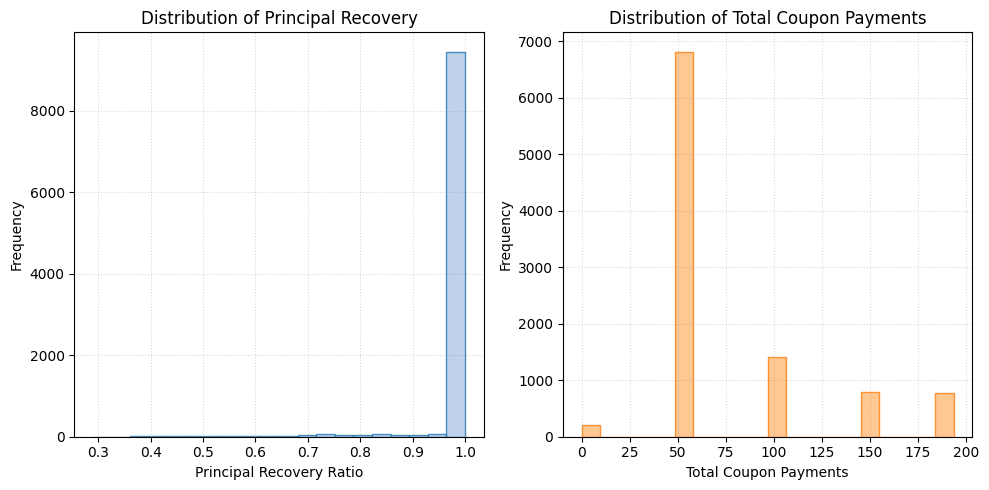

In [199]:
def plot_probability_distributions(results_df, nominal):
    """Plots the probability distributions for principal recovery and total coupon payments."""

    plt.figure(figsize=(10, 5))

    # Principal Recovery Distribution
    plt.subplot(1, 2, 1)
    plt.hist(results_df['principal'] / nominal, bins=20,
             edgecolor='#1f77b4', color='#aec7e8', alpha=0.8)
    plt.xlabel('Principal Recovery Ratio')
    plt.ylabel('Frequency')
    plt.title('Distribution of Principal Recovery')
    plt.grid(True, color='gray', linestyle=':', alpha=0.3)

    # Total Coupon Payments Distribution
    plt.subplot(1, 2, 2)
    total_coupon_payments = results_df['coupon_schedule'].apply(lambda x: sum(c['amount'] for c in x))
    plt.hist(total_coupon_payments, bins=20,
             edgecolor='#ff7f0e', color='#ffbb78', alpha=0.8)
    plt.xlabel('Total Coupon Payments')
    plt.ylabel('Frequency')
    plt.title('Distribution of Total Coupon Payments')
    plt.grid(True, color='gray', linestyle=':', alpha=0.3)

    plt.tight_layout()
    plt.show()

# Call function to generate plots
plot_probability_distributions(results_df, nominal)

In [196]:
# Estimate fair price
fair_price = np.mean(model.predict(paths[-1, :].reshape(-1, 1)))

print(f"Estimated Fair Price of the Note: ${fair_price:.2f}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Estimated Fair Price of the Note: $1024.61
